In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from loader_clone import create_loaders

In [2]:
loader, _ = create_loaders()

demo_genres_embeddings = np.load('demo_genres_embeddings.npy')
demo_plot_embeddings = np.load('demo_plot_embeddings.npy')

(1525, 384) (1525, 384)
(9456, 384) (9456, 384)
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (3536742, 5), n_users = 9612, n_items = 1525
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456


In [3]:

sim_matrix = cosine_similarity(demo_genres_embeddings)
triu_indices = np.triu_indices_from(sim_matrix, k=1) # avoid duplicates ij - ji
genre_sim_scores = sim_matrix[triu_indices]

sim_matrix = cosine_similarity(demo_plot_embeddings)
triu_indices = np.triu_indices_from(sim_matrix, k=1) # avoid duplicates ij - ji
plot_sim_scores = sim_matrix[triu_indices]

min_sim = plot_sim_scores.min()
max_sim = plot_sim_scores.max()

def min_max_norm(raw_sim, min_val, max_val):
    return (raw_sim - min_val) / (max_val - min_val)

## Diversity phase

In diversity phase, we want to show pairs of movies that are similar in genres but different in plot, and vice versa. And let them rate how diverse they are.


### Genres 

As a pair we select the most similar movies by genre embedding (same genres) but different plot


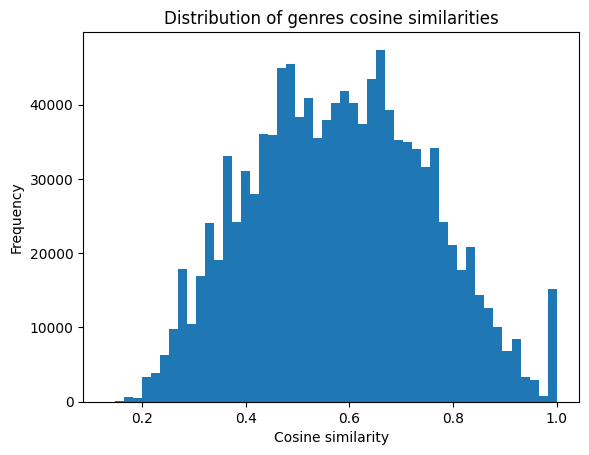

In [4]:

plt.hist(genre_sim_scores, bins=50)
plt.title("Distribution of genres cosine similarities")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.show()

In [5]:
print("Genres")
print(f"Mean similarity: {np.mean(genre_sim_scores):.3f}")
print(f"Standard deviation: {np.std(genre_sim_scores):.3f}")
print(f"Max similarity: {np.max(genre_sim_scores):.3f}")
print(f"Min similarity: {np.min(genre_sim_scores):.3f}")

Genres
Mean similarity: 0.582
Standard deviation: 0.170
Max similarity: 1.000
Min similarity: 0.129


In [6]:
N = 100
threshold = 0.9

valid_indices = np.where(genre_sim_scores < threshold)[0]
top_n_valid = valid_indices[np.argsort(-genre_sim_scores[valid_indices])[:N]]

def are_same(movie_a, movie_b):
    j_parts = movie_a.split(" ")
    for i_part in movie_b.split(" "):
        for j_part in j_parts:
            if j_part.startswith(i_part) or i_part.startswith(j_part):
                return True

def wrap_text(text, width=50):
    return [text[i:i+width] for i in range(0, len(text), width)]

sim_genre_pairs = []
added_movie_ids = set()

for rank, flat_idx in enumerate(top_n_valid, start=1):
    i, j = triu_indices[0][flat_idx], triu_indices[1][flat_idx]
    plot_sim = plot_sim_scores[flat_idx]
    plot_sim = min_max_norm(plot_sim, min_sim, max_sim)
    genre_sim = genre_sim_scores[flat_idx]

    if plot_sim > 0.5:
        continue

    movie_i = loader.movies_df.iloc[i]
    movie_j = loader.movies_df.iloc[j]

    title_i = movie_i.title
    title_j = movie_j.title

    movie_id_i = int(movie_i['movieId'])
    movie_id_j = int(movie_j['movieId'])

    # Skip if either movie is already added
    if movie_id_i in added_movie_ids or movie_id_j in added_movie_ids:
        continue

    if are_same(title_i, title_j):
        continue

    if len(sim_genre_pairs) < 9:  # Ensure multiple of 3
        sim_genre_pairs.append(
            {
                "pair": (movie_id_i, movie_id_j),
                "version": "sim_genres",
                "plot_sim": float(plot_sim),
                "genre_sim": float(genre_sim),
            }
        )
        added_movie_ids.update([movie_id_i, movie_id_j])

        genres_i = movie_i.genres
        genres_j = movie_j.genres
        plot_i_wrapped = wrap_text(movie_i["plot"])
        plot_j_wrapped = wrap_text(movie_j["plot"])
        max_lines = max(len(plot_i_wrapped), len(plot_j_wrapped))

        print(f"{rank:>2}. plot_sim = {plot_sim:.3f} genre_sim = {genre_sim:.3f}")
        print(f"{title_i:<51} ----- {title_j:<51}")
        print(f"{genres_i:<51} ----- {genres_j:<51}")
        for line_idx in range(max_lines):
            left_line = plot_i_wrapped[line_idx] if line_idx < len(plot_i_wrapped) else ''
            right_line = plot_j_wrapped[line_idx] if line_idx < len(plot_j_wrapped) else ''
            print(f"{left_line:<51} ----- {right_line:<51}")

with open('div_phase_genres_pairs.json', 'w') as f:
    json.dump(sim_genre_pairs, f, indent=4)

 2. plot_sim = 0.199 genre_sim = 0.900
North by Northwest (1959)                           ----- Mummy Returns, The (2001)                          
Action, Adventure, Mystery, Romance, Thriller       ----- Action, Adventure, Comedy, Thriller                
A New York City advertising executive goes on the   ----- The mummified body of Imhotep is shipped to a muse 
run after being mistaken for a government agent by  ----- um in London, where he once again wakes and begins 
 a group of foreign spies, and falls for a woman w  -----  his campaign of rage and terror.                  
hose loyalties he begins to doubt.                  -----                                                    
 3. plot_sim = 0.319 genre_sim = 0.900
Inception (2010)                                    ----- Elysium (2013)                                     
Action, Crime, Drama, Mystery, Sci-Fi, Thriller, IMAX ----- Action, Drama, Sci-Fi, IMAX                        
A thief who steals corporate secrets thr

### Same for plot ?

Well ...

#### Detour, normalization of similarity for plots

Noticed that the similarity for plots tends to be in between 0.3 and 0.5, and very few movies have similarity above or below that range. Since genre similarity is defined in 0-1 range, we should normalize the plot similarity to be in the same range.

First we analyze the distribution of plot similarity values.



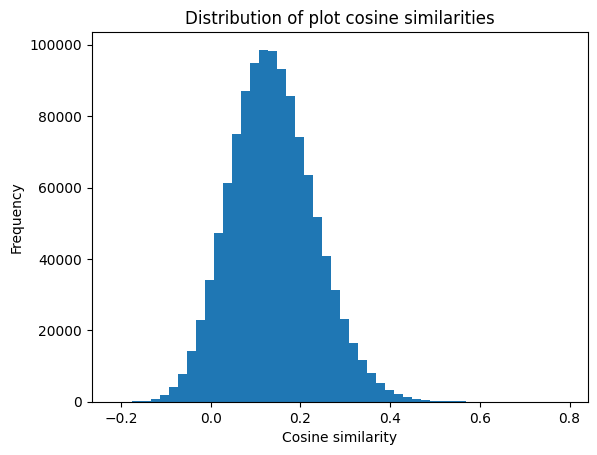

In [7]:

plt.hist(plot_sim_scores, bins=50)
plt.title("Distribution of plot cosine similarities")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.show()

In [8]:
print("Plots")
print(f"Mean similarity: {np.mean(plot_sim_scores):.3f}")
print(f"Standard deviation: {np.std(plot_sim_scores):.3f}")
print(f"Max similarity: {np.max(plot_sim_scores):.3f}")
print(f"Min similarity: {np.min(plot_sim_scores):.3f}")

Plots
Mean similarity: 0.138
Standard deviation: 0.095
Max similarity: 0.791
Min similarity: -0.215


In [9]:
N = 300
threshold = 0.9

valid_indices = np.where(plot_sim_scores < threshold)[0]
top_n_valid = valid_indices[np.argsort(-plot_sim_scores[valid_indices])[:N]]

def are_same(movie_a, movie_b):
    j_parts = movie_a.split(" ")
    for i_part in movie_b.split(" "):
        for j_part in j_parts:
            if j_part.startswith(i_part) or i_part.startswith(j_part):
                return True

def wrap_text(text, width=50):
    return [text[i:i+width] for i in range(0, len(text), width)]

sim_plot_pairs = []
added_movie_ids = set()  # Track which movies have already been included

for rank, flat_idx in enumerate(top_n_valid, start=1):
    i, j = triu_indices[0][flat_idx], triu_indices[1][flat_idx]
    plot_sim = plot_sim_scores[flat_idx]
    plot_sim = min_max_norm(plot_sim, min_sim, max_sim)
    genre_sim = genre_sim_scores[flat_idx]

    if genre_sim > 0.5:
        continue

    movie_i = loader.movies_df.iloc[i]
    movie_j = loader.movies_df.iloc[j]

    movie_id_i = int(movie_i['movieId'])
    movie_id_j = int(movie_j['movieId'])

    title_i = movie_i.title
    title_j = movie_j.title

    # Skip if either movie already used
    if movie_id_i in added_movie_ids or movie_id_j in added_movie_ids:
        continue

    if are_same(title_i, title_j):
        continue

    if len(sim_plot_pairs) < 9:  # Ensure multiple of 3
        sim_plot_pairs.append(
            {
                "pair": (movie_id_i, movie_id_j),
                "version": "sim_plot",
                "plot_sim": float(plot_sim),
                "genre_sim": float(genre_sim),
            }
        )
        added_movie_ids.update([movie_id_i, movie_id_j]) 

        genres_i = movie_i.genres
        genres_j = movie_j.genres
        plot_i_wrapped = wrap_text(movie_i["plot"])
        plot_j_wrapped = wrap_text(movie_j["plot"])
        max_lines = max(len(plot_i_wrapped), len(plot_j_wrapped))

        print(f"{rank:>2}. plot_sim = {plot_sim:.3f} genre_sim = {genre_sim:.3f}")
        print(f"{title_i:<51} ----- {title_j:<51}")
        print(f"{genres_i:<51} ----- {genres_j:<51}")
        for line_idx in range(max_lines):
            left_line = plot_i_wrapped[line_idx] if line_idx < len(plot_i_wrapped) else ''
            right_line = plot_j_wrapped[line_idx] if line_idx < len(plot_j_wrapped) else ''
            print(f"{left_line:<51} ----- {right_line:<51}")

with open('div_phase_plot_pairs.json', 'w') as f:
    json.dump(sim_plot_pairs, f, indent=4)


79. plot_sim = 0.835 genre_sim = 0.388
Sleeping Beauty (1959)                              ----- Pan's Labyrinth (Laberinto del fauno, El) (2006)   
Animation, Children, Musical                        ----- Drama, Fantasy, Thriller                           
After being snubbed by the royal family, a malevol  ----- In 1944 Spain, a girl is sent to live with her rut 
ent fairy places a curse on a princess which only   ----- hless stepfather. During the night, she meets a fa 
a prince can break, along with the help of three g  ----- iry who takes her to an old faun. He tells her she 
ood fairies.                                        ----- &#x27;s a princess, but must prove her royalty by  
                                                    ----- surviving three gruesome tasks.                    
108. plot_sim = 0.817 genre_sim = 0.396
Mission: Impossible (1996)                          ----- Jason Bourne (2016)                                
Action, Adventure, Mystery, Thriller     

In [10]:
import json
import random

with open('div_phase_genres_pairs.json') as f:
    genres_pairs = json.load(f)

with open('div_phase_plot_pairs.json') as f:
    plot_pairs = json.load(f)

def select_pairs():
    # 3 genre pairs + 3 plot pairs, then shuffle to mix
    pairs = random.sample(genres_pairs, 3) + random.sample(plot_pairs, 3)
    return pairs

def compute_deltas(pairs):
    # For each pair, compute how strongly it pushes toward plot or genre
    deltas = []
    for pair in pairs:
        plot_sim = pair['plot_sim']
        genre_sim = pair['genre_sim']
        diff = abs(plot_sim - genre_sim)
        direction = 1 if plot_sim > genre_sim else -1
        deltas.append(direction * diff)
    return deltas

def compute_stimulus_score(deltas, ratings):
    score = 0.0
    for delta, rating in zip(deltas, ratings):
        if rating in [1, 2]:
            score += delta
        elif rating in [4, 5]:
            score -= delta
        # rating == 3 does nothing
    return score

def determine_stimulus(score):
    return "genre" if score < 0 else "plot"

In [11]:
for i in range(10):
    pairs = select_pairs()
    deltas = compute_deltas(pairs)
    max_score = sum(abs(d) for d in deltas)
    min_score = -max_score

    # Random ratings: first 3 from [3,4,5], last 3 from [3,2,1]
    ratings = [random.choice([3,4,5]) for _ in range(3)] + [random.choice([3,2,1]) for _ in range(3)]

    score = compute_stimulus_score(deltas, ratings)
    preference = determine_stimulus(score)

    print(f"Ratings given: {ratings}")
    print(f"Stimulus score: {score:.4f}")
    print(f"Score range: {min_score:.4f} - {max_score:.4f}")
    print(f"Stimulus: {preference}\n")

Ratings given: [5, 3, 4, 1, 3, 2]
Stimulus score: 1.9979
Score range: -2.7658 - 2.7658
Stimulus: plot

Ratings given: [3, 5, 5, 1, 3, 1]
Stimulus score: 1.6996
Score range: -2.5806 - 2.5806
Stimulus: plot

Ratings given: [3, 3, 5, 2, 3, 1]
Stimulus score: 1.1356
Score range: -2.7627 - 2.7627
Stimulus: plot

Ratings given: [4, 4, 4, 2, 1, 3]
Stimulus score: 2.2820
Score range: -2.6633 - 2.6633
Stimulus: plot

Ratings given: [3, 5, 5, 2, 3, 3]
Stimulus score: 1.6362
Score range: -2.8753 - 2.8753
Stimulus: plot

Ratings given: [5, 3, 5, 3, 3, 1]
Stimulus score: 1.2748
Score range: -2.5095 - 2.5095
Stimulus: plot

Ratings given: [3, 3, 4, 1, 2, 1]
Stimulus score: 1.8365
Score range: -2.8436 - 2.8436
Stimulus: plot

Ratings given: [3, 4, 5, 3, 1, 1]
Stimulus score: 1.9857
Score range: -2.9160 - 2.9160
Stimulus: plot

Ratings given: [4, 4, 5, 3, 2, 2]
Stimulus score: 2.0723
Score range: -2.4929 - 2.4929
Stimulus: plot

Ratings given: [4, 3, 4, 1, 1, 1]
Stimulus score: 2.1527
Score range: -2.

In [12]:
for i in range(10):
    pairs = select_pairs()
    deltas = compute_deltas(pairs)
    max_score = sum(abs(d) for d in deltas)
    min_score = -max_score

    # Random ratings: first 3 from [3,2,1], last 3 from [3,4,5]
    ratings = [random.choice([3, 2, 1]) for _ in range(3)] + [random.choice([3, 4, 5]) for _ in range(3)]

    score = compute_stimulus_score(deltas, ratings)
    preference = determine_stimulus(score)

    print(f"Ratings given: {ratings}")
    print(f"Stimulus score: {score:.4f}")
    print(f"Score range: {min_score:.4f} - {max_score:.4f}")
    print(f"Stimulus: {preference}\n")


Ratings given: [1, 3, 2, 4, 5, 3]
Stimulus score: -1.7046
Score range: -2.6670 - 2.6670
Stimulus: genre

Ratings given: [1, 1, 1, 4, 3, 4]
Stimulus score: -2.2583
Score range: -2.5848 - 2.5848
Stimulus: genre

Ratings given: [3, 3, 1, 4, 4, 3]
Stimulus score: -1.3544
Score range: -2.9602 - 2.9602
Stimulus: genre

Ratings given: [1, 1, 1, 4, 3, 3]
Stimulus score: -1.9351
Score range: -2.5811 - 2.5811
Stimulus: genre

Ratings given: [2, 3, 1, 3, 4, 3]
Stimulus score: -1.5394
Score range: -2.7902 - 2.7902
Stimulus: genre

Ratings given: [2, 3, 3, 5, 5, 3]
Stimulus score: -1.1710
Score range: -2.5942 - 2.5942
Stimulus: genre

Ratings given: [3, 1, 2, 4, 5, 5]
Stimulus score: -2.2473
Score range: -2.6498 - 2.6498
Stimulus: genre

Ratings given: [3, 3, 1, 5, 3, 4]
Stimulus score: -1.1497
Score range: -2.4438 - 2.4438
Stimulus: genre

Ratings given: [1, 3, 2, 5, 3, 5]
Stimulus score: -1.9613
Score range: -2.9041 - 2.9041
Stimulus: genre

Ratings given: [2, 3, 3, 3, 5, 3]
Stimulus score: -0.77